In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

In [61]:
POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
# coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [62]:
def get_density2D(f, data, steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:, 0].min(), data[:, 0].max()
    ymin, ymax = data[:, 1].min(), data[:, 1].max()
    xlin, ylin = np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin


def show_density(f, data, steps=100, log=False):
    """
    Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    # extent pour controler l'echelle du plan


def load_poi(typepoi, fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1], v[1][0][0]]
                    for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data, note


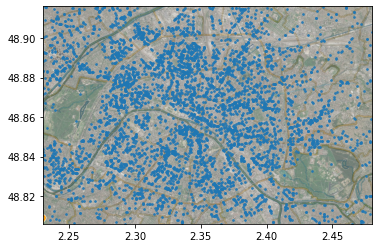

In [63]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:, 0], geo_mat[:, 1], alpha=0.8, s=3)

# Methode par Histogramme

In [64]:
class Density(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, data):
        pass

    def predict(self, data):
        pass

    def score(self, data):
        density = self.predict(data)
        return np.log( np.where(density == 0, 1e-10, density) ).sum()

In [65]:
class Histogramme(Density):
	def __init__(self, steps=10):
		Density.__init__(self)
		self.steps = steps
		self.density = None
		self.bins = None

	def fit(self, x):
		"""
		Apprend l'histogramme de la densité sur x
		"""
		self.density, self.bins = np.histogramdd(
			x, bins=[self.steps]*x.shape[-1], density=True
		)


	def predict(self, x):
		"""
		Retourne la densité associée à chaque point de x
		"""
		def to_bin(x):
			"""
			Assez tricky comme solution mais marche pour toute dimension
			Pour chaque dimension je regarde le bin associé. Pour comprendre rapidement la fonction, print les éléments

			En faite on peut tout faire avec un np.searchsorted() ................. Merci Aymeric............
			"""
			oui = np.stack(self.bins, axis=1)
			# Exception pour les points représentant les bornes de l'Histogramme, 
			# On les augmente un peu pour faire les faire rentrer
			# Evite un test dans la boucle 
			oui[-1] += 1e-10
			
			l = []
			xi_dim = x.shape[-1]
			for xi in x:
				tmp = []
				for i in range(xi_dim):
					oui_i = oui[..., i]
					xij = xi[..., i]
					if oui_i[-1] < xij or xij < oui_i[0]:
						tmp.append(None)
					else:
						where = np.nonzero(oui[..., i] <= xi[..., i])[-1]
						tmp.append(where[-1])
						# where = np.where(where == self.steps, self.steps - 1, where) # exception pour les points représentant les bornes de l'Histogramme 
				l.append(tuple(tmp))
			return l

		prediction = []
		for i, cords in enumerate(to_bin(x)):
			if cords.count(None) != 0:
				prediction.append(0)
			else:
				prediction.append(self.density[cords])
		return np.array(prediction)

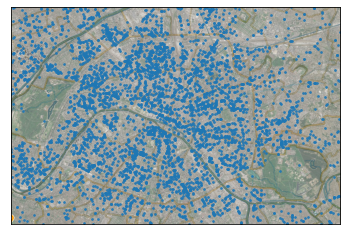

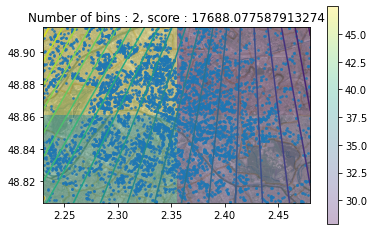

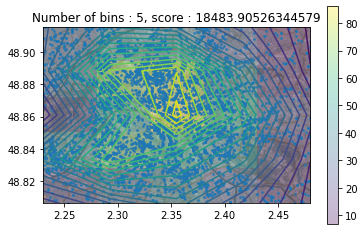

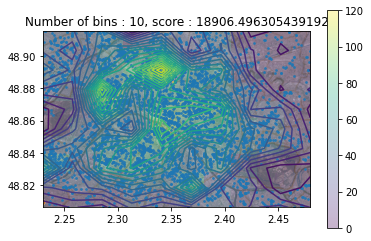

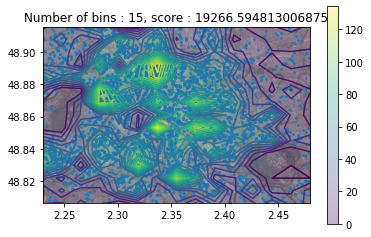

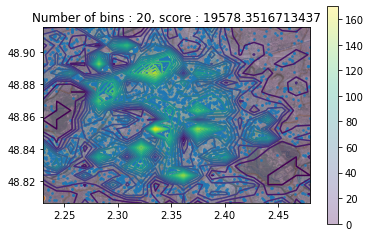

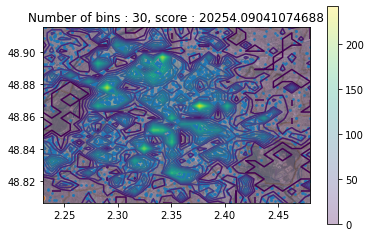

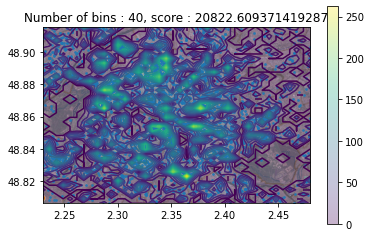

In [66]:
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for steps in [2, 5, 10, 15, 20, 30, 40]:
    nc_hist = Histogramme(steps)
    nc_hist.fit(geo_mat)
    nc_hist.predict(geo_mat)
    show_density(nc_hist, geo_mat, steps)
    plt.gca().set_title(f'Number of bins : {steps}, score : {nc_hist.score(geo_mat)}')

## Validation croisé

### Restaurant

Meilleurs steps : 17


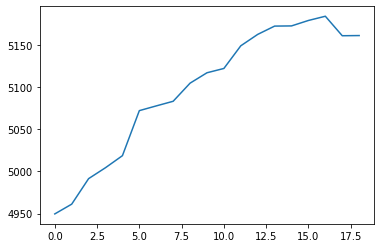

In [67]:
mean_list = []
steps_list = []
for steps in range(1, 20):
    geo_mat, notes = load_poi("restaurant")
    score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
    mean_list.append(np.mean(score_list))
    steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

### Night_club

Meilleurs steps : 5


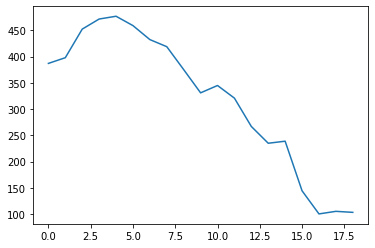

In [68]:
mean_list = []
steps_list = []
for steps in range(1, 20):
    geo_mat, notes = load_poi("night_club")
    score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
    mean_list.append(np.mean(score_list))
    steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

# Méthodes à noyaux

In [69]:
def kernel_uniform(x):
    bool_list = (np.abs(x) < 0.5).all(axis=1)
    return np.where(bool_list, 1, 0)

In [70]:
test_x = np.array(
    [[0.25, 0.2, 0.45],
    [0.25, 0.2, 0.55],
    [12991.70085, 271411.03284, 0.4],
    [12991.619831, 271411.321743, 0.4],
    [12991.763074, 271411.541286, 0.4]],
)
kernel_uniform(test_x)

array([1, 0, 0, 0, 0])

In [71]:
def kernel_gaussian(x):
    d = x.shape[-1]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) 

In [72]:
kernel_gaussian(test_x)

array([0.05451303, 0.05185439, 0.        , 0.        , 0.        ])

In [73]:
class KernelDensity(Density):
    def __init__(self, kernel=None, sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, x):
        self.x = x

    def predict(self, data):
        # retourne la densité associée à chaque point de data
        n, d = self.x.shape
        l = []
        for x_i in data:
            x_i_stacked = np.vstack([x_i]*n)
            sum_value = self.kernel((x_i_stacked - self.x)/self.sigma).sum()
            l.append(sum_value / (n*self.sigma**d))
        return np.array(l)

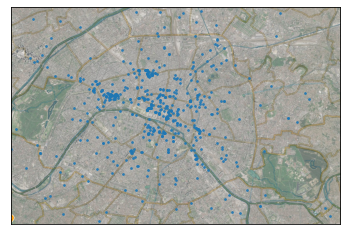

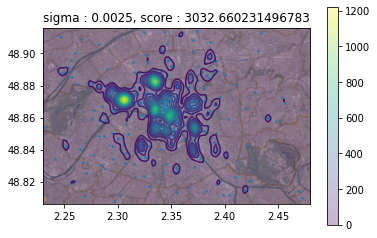

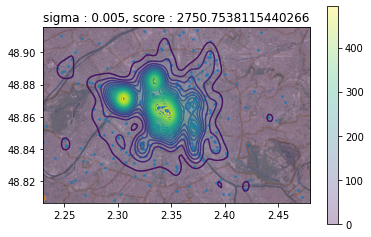

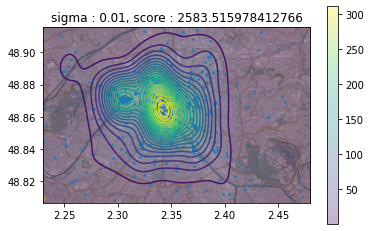

In [74]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.0025, 0.005, 0.01]:
    nc_kernelDensity = KernelDensity(kernel=kernel_gaussian, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')

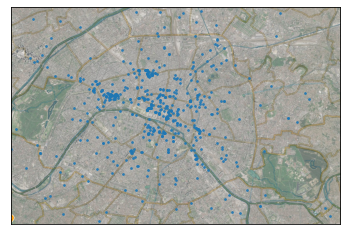

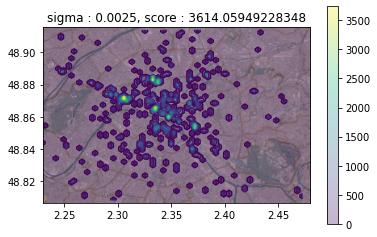

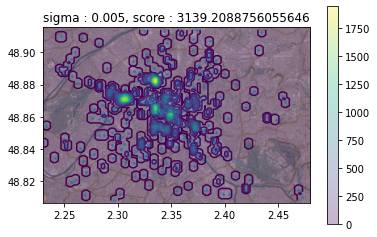

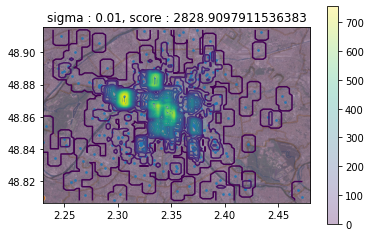

In [77]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.0025, 0.005, 0.01]:
    nc_kernelDensity = KernelDensity(kernel=kernel_uniform, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')

# Nadaraya-Watson

In [76]:
class Nadaraya(Density):
    def __init__(self, kernel, sigma) -> None:
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma
    
    def fit(self, x, y):
        self.x = x
        self.y = y

    def predict(self, data):
        prediction = []
        for x in data:
            noyau = self.kernel((x - self.x) / self.sigma) + 1e-10
            prediction.append(np.sum(self.y * noyau) / np.sum(noyau))
        return np.array(prediction)